# Two body scattering

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from functions import * #Import the functions given in the lecture  
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('wf-obe-lam=800.00.dat', delimiter=';')


Lambda = 800
C0 = 2.470795e-02
hbarc = 197.327
E = -2.225/hbarc
mu =  938.92/hbarc
A = -0.1544435 
m_B = 138
p = np.array(data[:,0])
p = np.append(p,0)
p_max = p[-2]
w = np.array(data[:,1])
w = np.append(w,0)
pot=OBEpot(nx=20,mpi=m_B,C0=C0,A=A,cutoff=Lambda)


In [3]:
def delta(i,j):
    if i==j:
        return 1
    else:
        return 0
def V_matrix(i,j,l):
    return pot.v(p[i],p[j],l)
    
def A_matrix(i,k,N,p_max,q,l):
    if k != N:
        return delta(i,k)-2*mu*V_matrix(i,k,l)*p[k]**2*w[k]/(q**2-p[k]**2)
    else:
        return delta(i,k)+np.sum(2*mu*V_matrix(i,N,l)*q**2*w[:-1]/(q**2-p[:-1]**2))-mu*q*V_matrix(i,N,l)*np.log((p_max+q)/(p_max-q))+1j*np.pi*mu*q*V_matrix(i,N,l)
    


def gen_matrices(N,q,l):
    p[-1] = q
    A_mat = []
    V_mat = []
    for i in range(N):
        A_mat.append([])
        V_mat.append([])
        for j in range(N):
            A_mat[i].append(A_matrix(i,j,N-1,p_max,q,l))
            V_mat[i].append(V_matrix(i,j,l))
    return A_mat, V_mat

def t_matrix(q,l):
    A_mat, V_mat = gen_matrices(len(p),q,l)
    return np.linalg.solve(A_mat, V_mat)

def S_matrix(q,l):
    return 1-2*1j*np.pi*mu*q*t_matrix(q,l)[-1][-1]

In [4]:
t_mat = t_matrix(1,0)
np.abs(S_matrix(1,0))

1.0000000000000007

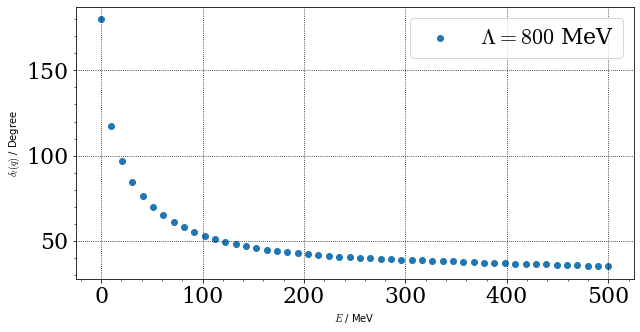

In [5]:
beauty_plot()
E_list = np.linspace(0,500,50)/hbarc
q_list = np.sqrt(np.array(E_list)*mu*2)
phase_shift = []
counter=0
for q in q_list:
    counter+=1
    phase_shift.append(np.real(-0.5*1j*np.log(S_matrix(q,0)))*180/np.pi)
    if phase_shift[-1]<0 or q<0.5:
        phase_shift[-1]=phase_shift[-1]+180

plt.scatter(E_list*hbarc,(np.array(phase_shift)), label = "$\Lambda=%d$ MeV"%(Lambda))
plt.xlabel("$E$ / MeV")
plt.ylabel("$\delta_l(q)$ / Degree")
plt.legend()
plt.show()

In [6]:
def cross_sec(mu,q,x,lmax):
    Pl=legendre(lmax)
    l_sum=np.sum([(2*l+1)*t_matrix(q,l)[-1][-1]*Pl(x) for l in range(0,lmax+1)])
    return np.pi**2*mu**2*np.abs(l_sum)**2

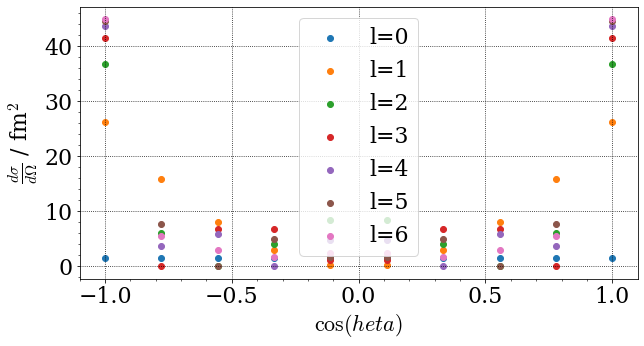

In [7]:
x=np.linspace(-1,1,10)
l_list=[i for i in range(0,7)]
beauty_plot()
for lmax in l_list:
    y=[cross_sec(mu,np.sqrt(2*10/hbarc*mu),x,lmax) for x in x]
    plt.plot(x,y,label="l=%d"%(lmax))
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("$\cos(\\theta)$")
plt.ylabel("$\\frac{d\sigma}{d\Omega}$ / fm$^{2}$")
plt.show()
